In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

In [90]:
df = pd.read_excel("premiums.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [91]:
df.shape

(50000, 13)

## 1). Data Cleaning & EDA

In [92]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [93]:
df.columns = df.columns.str.replace(' ' , '_').str.lower()

In [94]:
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


### Handle NA Values

In [95]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [96]:
df.dropna(inplace = True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [97]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Handle Outliers

In [98]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [99]:
df[df.number_of_dependants < 0].shape

(72, 13)

In [100]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [101]:
# 'number_of_dependants' column contain -3 and -1 values for 72 rows

In [102]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [103]:
numeric_columns = df.select_dtypes(['float64' , 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

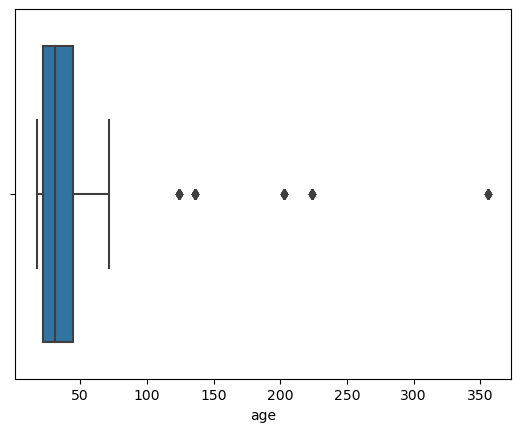

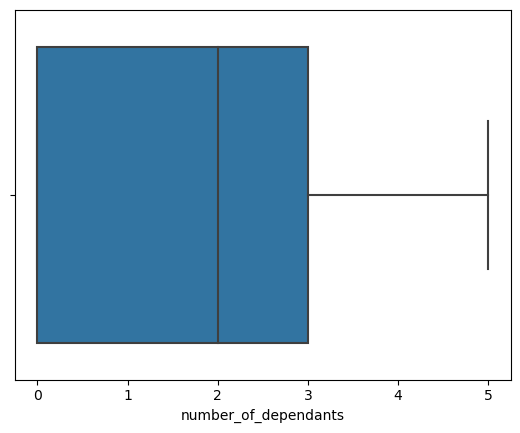

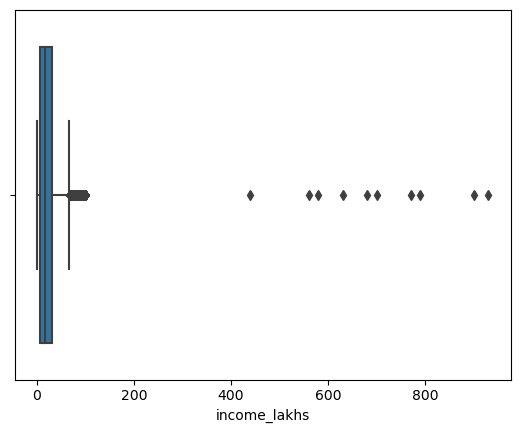

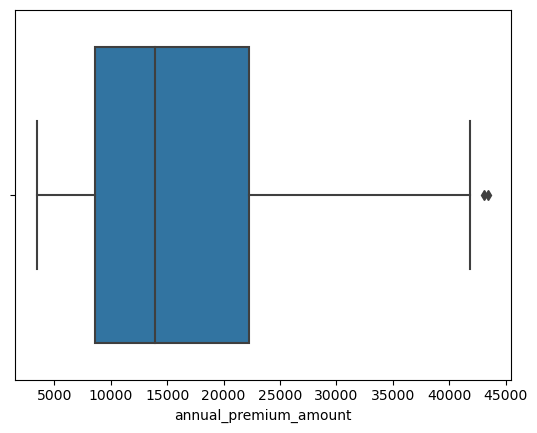

In [104]:
for col in numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()

In [105]:
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [106]:
df1 = df[df.age <=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [107]:
df1.income_lakhs.quantile([0.25 , 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [108]:
def get_iqr_bounds(col):
    Q1 , Q3 = col.quantile([0.25 , 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound
    

In [109]:
get_iqr_bounds(df1.income_lakhs)

(-29.0, 67.0)

In [110]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [111]:
df1[df1.income_lakhs > quantile_thresold].shape

(10, 13)

In [112]:
df2 = df1[df1.income_lakhs <= quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


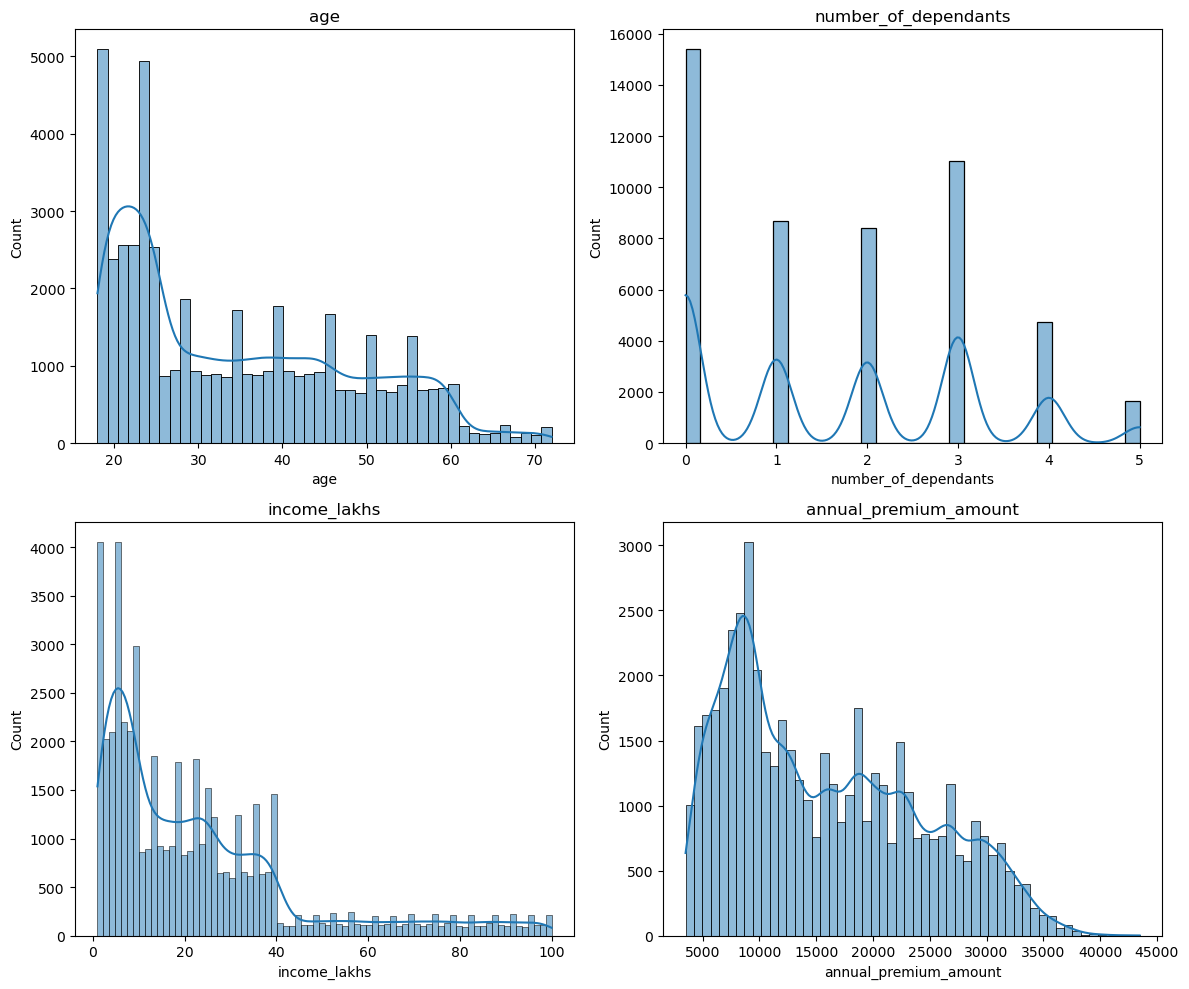

In [113]:


fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 subplot grid
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])  # Assign each plot to a subplot
    axes[i].set_title(col)  # Add column name as title
    

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

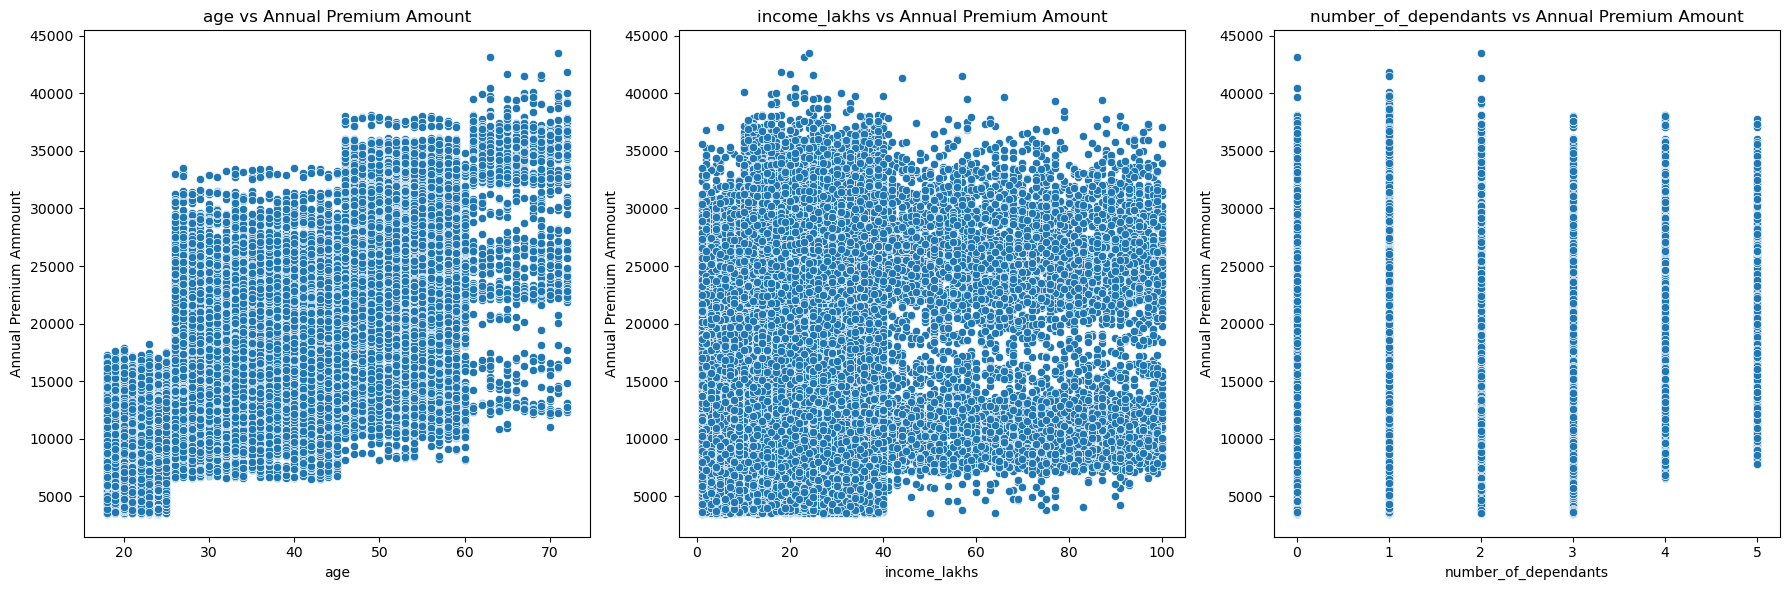

In [114]:
numeric_features = ['age' , 'income_lakhs' , 'number_of_dependants']

fig , axes = plt.subplots(1 , len(numeric_features) , figsize = (18,6))
axes = axes.flatten()

for i , column in enumerate(numeric_features):
    sns.scatterplot(x = df2[column] , y = df2["annual_premium_amount"] , ax= axes[i])
    axes[i].set_title(f'{column} vs Annual Premium Amount')   
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Annual Premium Ammount")
    
plt.tight_layout()
plt.show()                

In [115]:
categorical_cols = df.select_dtypes(['object' , 'category']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [116]:
for col in categorical_cols:
    print(col , ":" , df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [117]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
    
} , inplace = True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [118]:
pct_count = df2['gender'].value_counts(normalize = True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

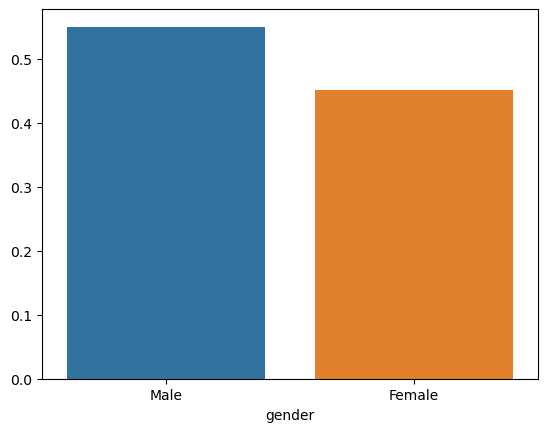

In [119]:
sns.barplot(x = pct_count.index , y = pct_count.values)

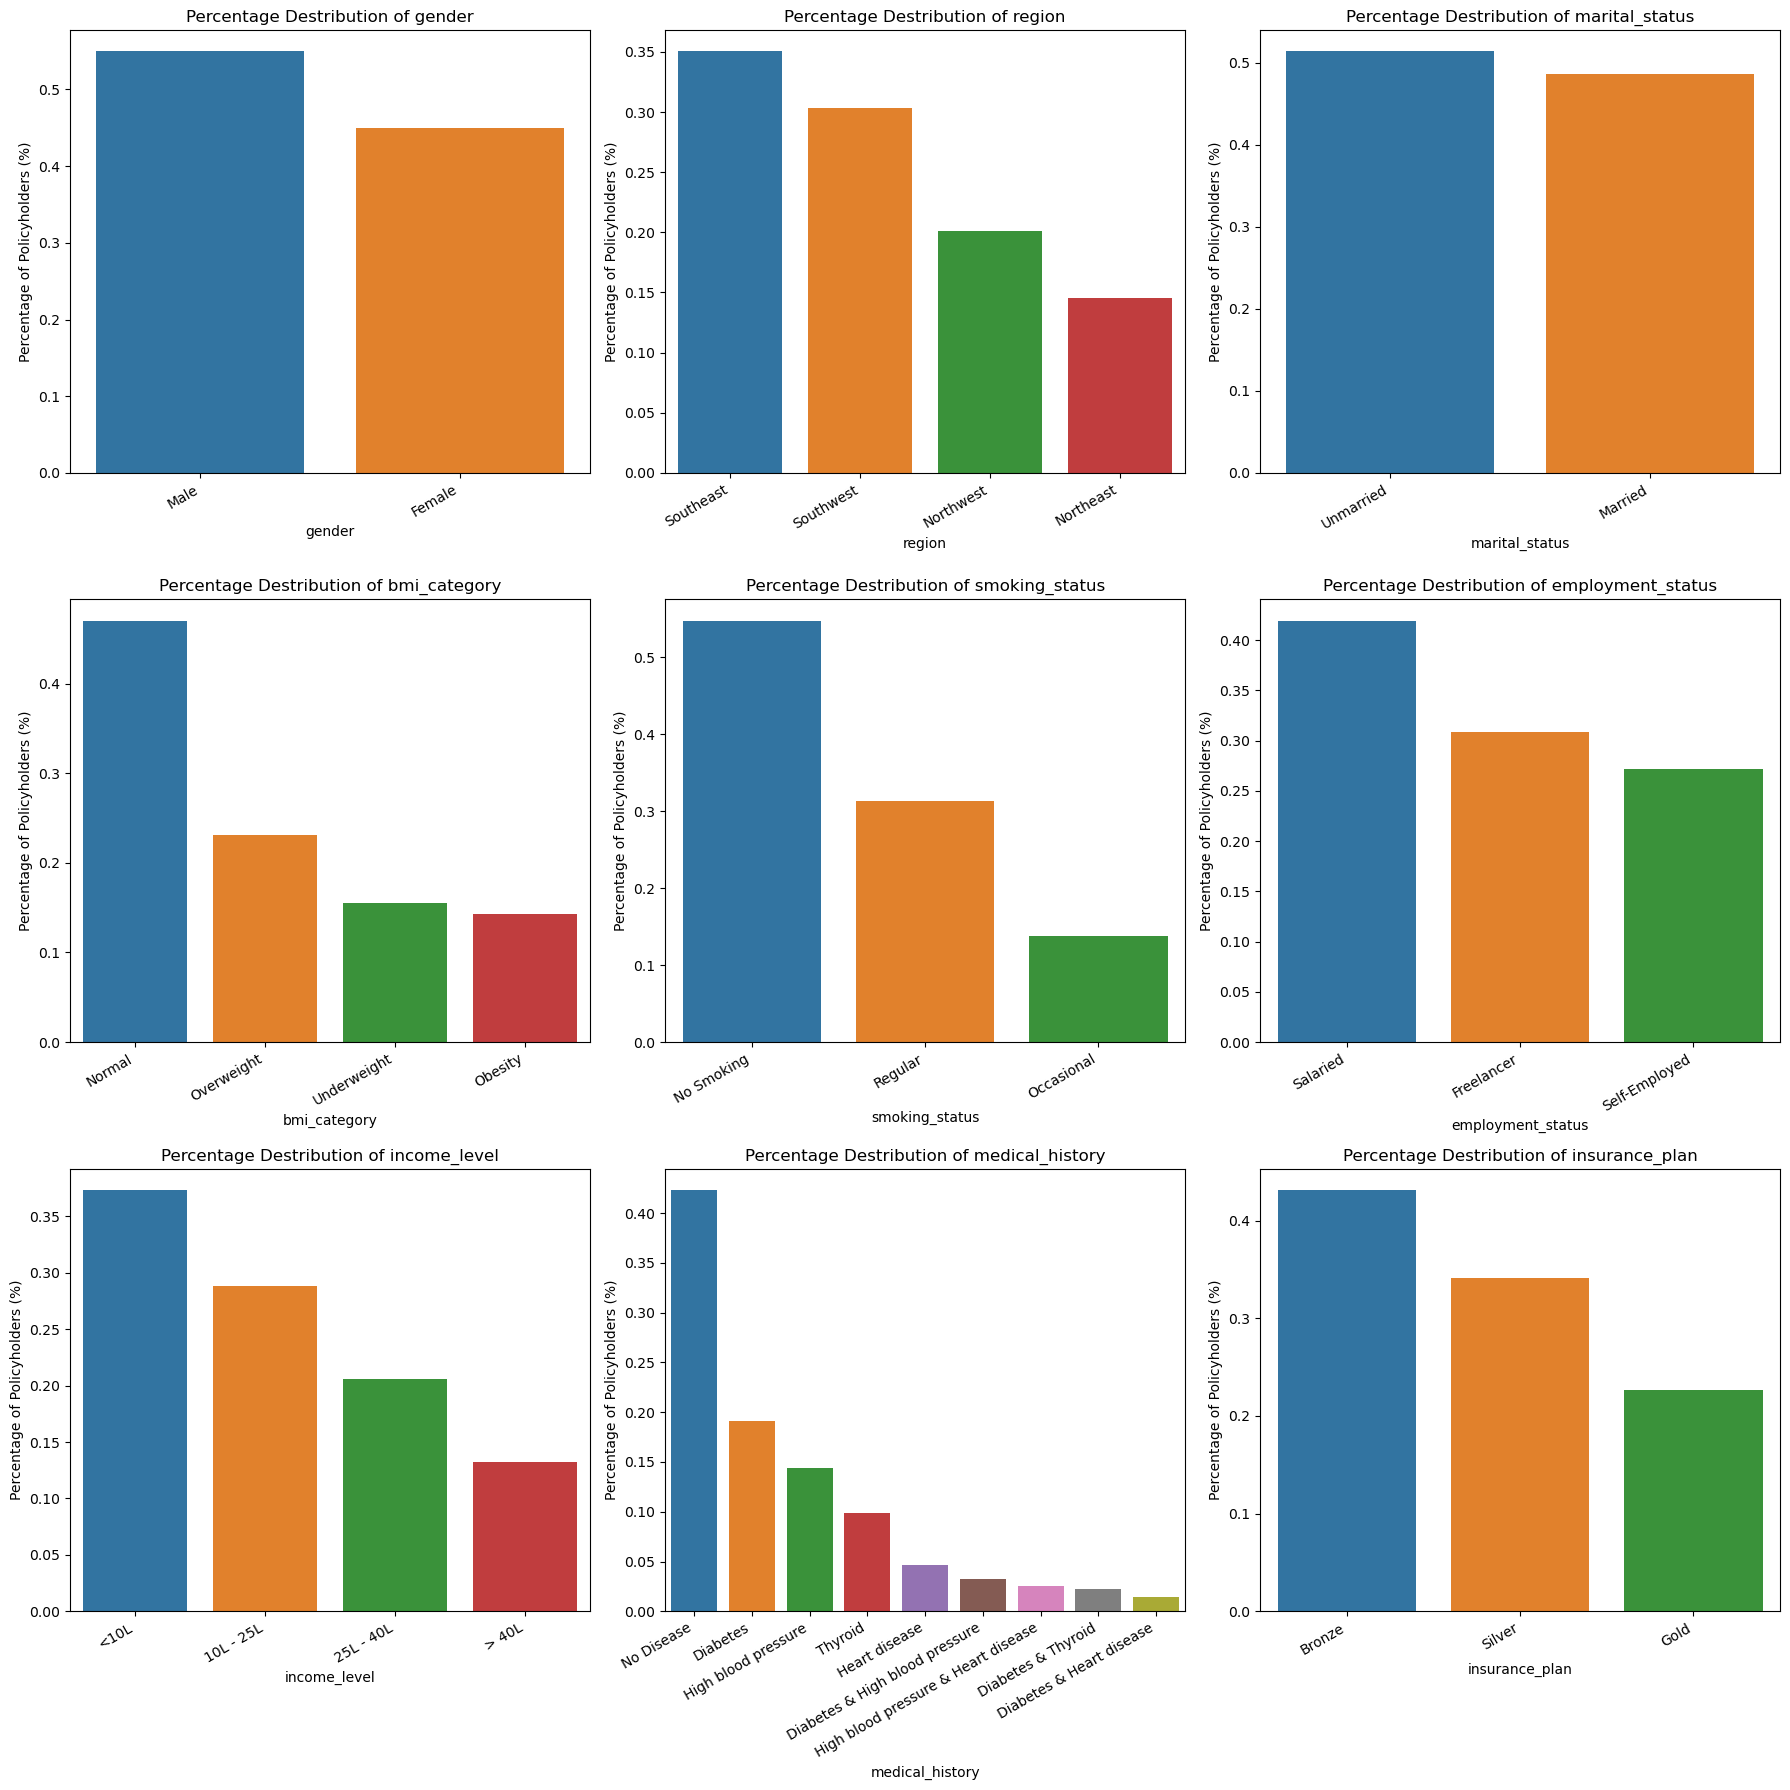

In [120]:
fig , axes = plt.subplots(3,3 , figsize =(18,18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    pct_count = df2[col].value_counts(normalize = True)
    sns.barplot(x = pct_count.index , y = pct_count.values , ax = axes[i])
    axes[i].set_title(f'Percentage Destribution of {col}')
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha="right", fontsize=10)
plt.tight_layout()
plt.show()
    
    

In [121]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,329,3653,2641


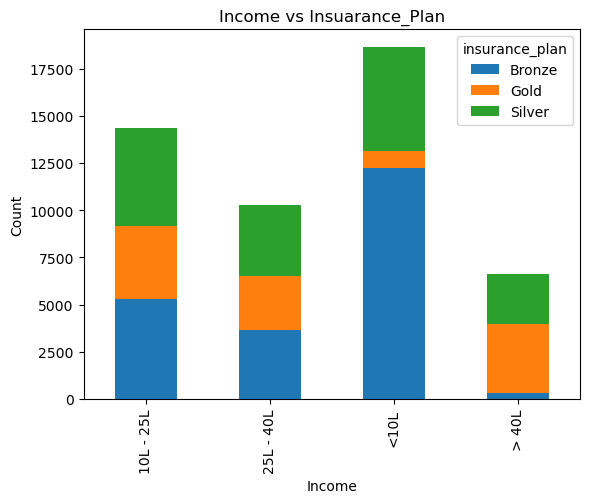

In [122]:
crosstab.plot(kind = 'bar' , stacked = True)
plt.title("Income vs Insuarance_Plan")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

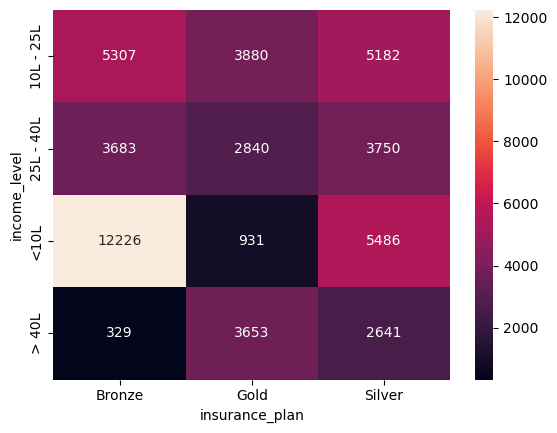

In [123]:
sns.heatmap(crosstab , annot =True , fmt = 'd')

## 2). Feature Engineering

In [124]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [125]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [126]:
risk_scores = {
    "diabetes" : 6 , 
    "heart disease":8,
    "high blood pressure" : 6,
    "thyroid" : 5 , 
    "no disease" : 0,
    "none":0
}

df2[['disease1' ,'disease2']] = df2['medical_history'].str.split(" & " , expand = True).apply(lambda x: x.str.lower())
# (split) devide column value by & and (expand) add to two columns
df2.head(2)



,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None


In [127]:
df2['disease1'].fillna('none' , inplace = True)
df2['disease2'].fillna('none' , inplace = True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)
    
min_score = df2['total_risk_score'].min()
max_score = df2['total_risk_score'].max()
                
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [128]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [129]:
df2["insurance_plan"] = df["insurance_plan"].map({'Bronze' : 1 , 'Silver' : 2 , 'Gold' : 3})
df2["insurance_plan"].unique()

array([1, 2, 3], dtype=int64)

In [130]:
df2["income_level"] = df["income_level"].map({'<10L' : 1 , '10L - 25L':2 , '25L - 40L':3 , '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [131]:
nominal_cols = ['gender','region','marital_status','bmi_category' , 'smoking_status','employment_status']

df3 = pd.get_dummies(df2 , columns = nominal_cols , drop_first=True , dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [132]:
df4 = df3.drop(['medical_history' , 'disease1','disease2','total_risk_score'],axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


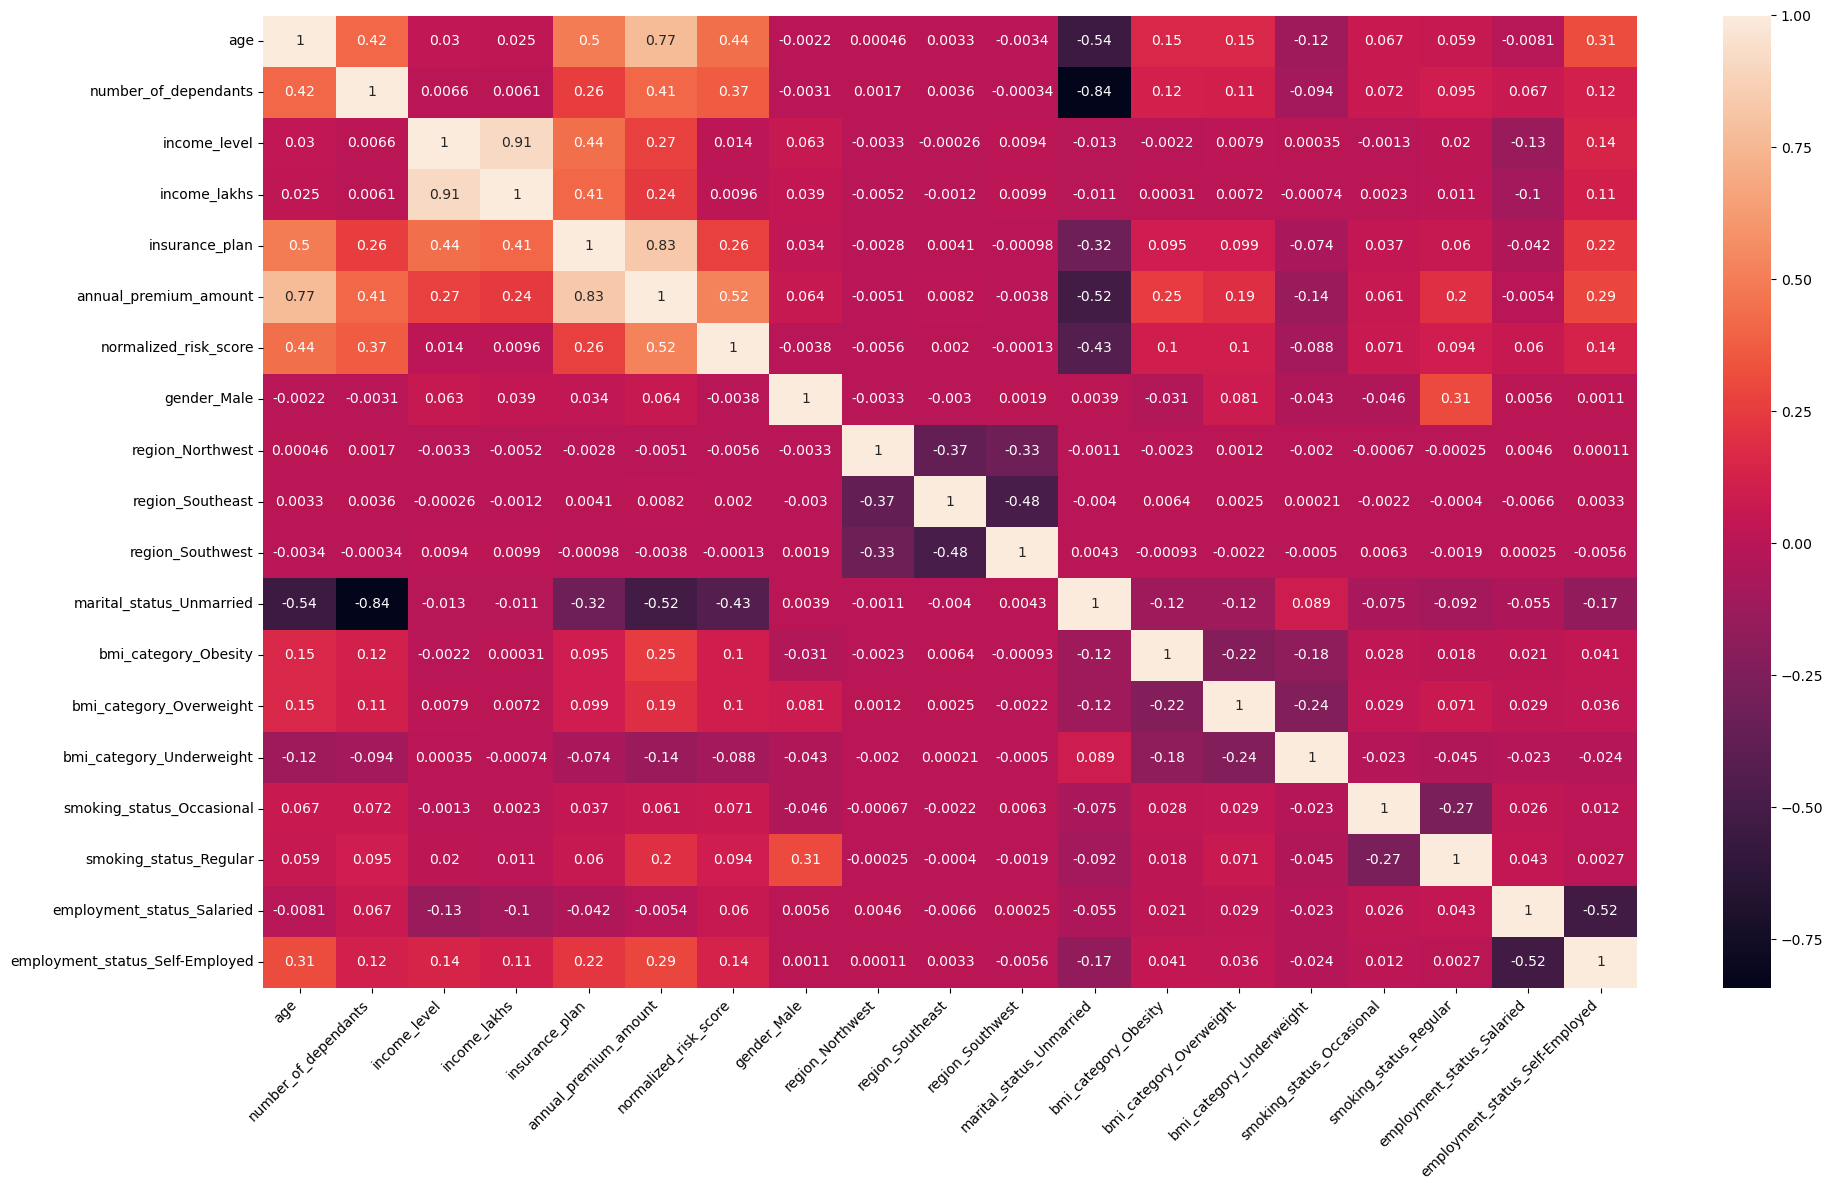

In [133]:
cm = df4.corr()      # correlation matrix

plt.figure(figsize =(20,12))
sns.heatmap(cm , annot = True)
plt.xticks(rotation =45 , ha ='right')
plt.yticks(rotation = 0 )
plt.tight_layout()
plt.show()

In [134]:
X = df4.drop('annual_premium_amount',axis = 1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [135]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values , i) for i in range(data.shape[1])]
    return vif_df


In [136]:
calculate_vif(X)

,column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [137]:
calculate_vif(X.drop('income_level',axis = 1))  # two column have vif greater thn 10 , firstly remove highest vif and recheck




,column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [138]:
X_reduced = X.drop('income_level',axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## 3). Model Training

In [139]:
X_train ,X_test , y_train ,y_test = train_test_split(X_reduced , y ,test_size = 0.3 , random_state = 10 )

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

X_train : (34935, 17)
X_test : (14973, 17)
y_train : (34935,)
y_test : (14973,)


In [140]:
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)

train_score = model_lr.score(X_train , y_train)
test_score = model_lr.score(X_test , y_test)

train_score , test_score

(0.9282143576916762, 0.9280547230217837)

In [141]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test , y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE :", mse_lr , " RMSE : ",rmse_lr)

Linear Regression ==> MSE : 5165611.913027984  RMSE :  2272.7982561212916


In [142]:
model_lr.intercept_

4824.300272127093

In [143]:
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [144]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance , index = X_test.columns , columns =['Coefficients'])
coef_df = coef_df.sort_values(by ='Coefficients',ascending = True)
coef_df


,Coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


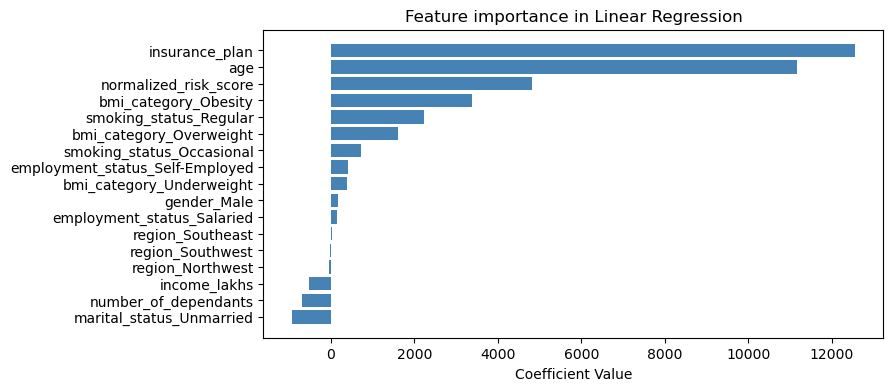

In [145]:
plt.figure(figsize = (8,4))
plt.barh(coef_df.index , coef_df["Coefficients"] , color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title("Feature importance in Linear Regression")
plt.show()

In [146]:
model_rg = Ridge()
model_rg.fit(X_train , y_train)

train_score = model_rg.score(X_train , y_train)
test_score = model_rg.score(X_test , y_test)

train_score , test_score


(0.9282143198366275, 0.9280541644640345)

In [147]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train , y_train)

train_score = model_xgb.score(X_train , y_train)
test_score = model_xgb.score(X_test , y_test)

train_score , test_score

(0.9860964164832711, 0.9809534637207582)

In [148]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test , y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE :", mse_xgb , " RMSE : ",rmse_xgb)

XGBoost Regression ==> MSE : 1367525.6922808294  RMSE :  1169.412541527082


In [149]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [150]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_


0.9809474553641963

In [151]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [152]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [153]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

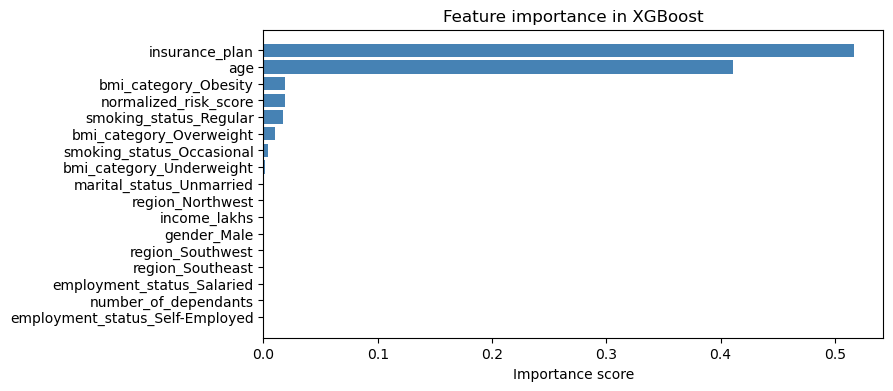

In [154]:
feature_importances = best_model.feature_importances_
feature_importances

coef_df = pd.DataFrame(feature_importances , index = X_test.columns , columns =['Coefficients'])
coef_df = coef_df.sort_values(by ='Coefficients',ascending = True)

plt.figure(figsize = (8,4))
plt.barh(coef_df.index , coef_df["Coefficients"] , color = 'steelblue')
plt.xlabel('Importance score')
plt.title("Feature importance in XGBoost")
plt.show()


## 4). Error Analysis

In [155]:
# works with test data set

In [156]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicated' : y_pred,
    'diff' : residuals,
    'diff_pct' : residuals_pct
})

results_df.head()

,actual,predicated,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

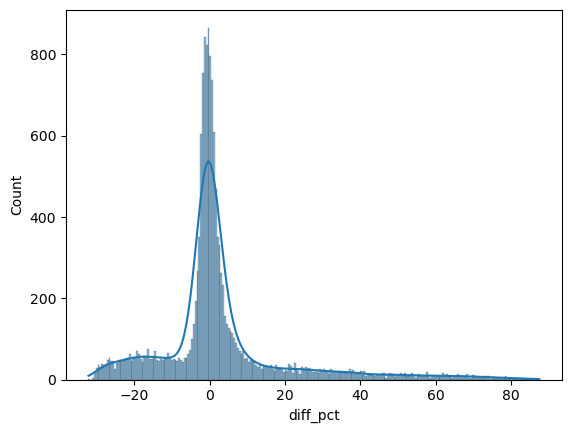

In [157]:
sns.histplot(results_df['diff_pct'] , kde = True)

In [158]:
extreme_error_threshold = 10        # our maximum error percentage is 10

extreme_results_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_results_df

,actual,predicated,diff,diff_pct
42730,5018,7352.829590,2334.829590,46.529087
20029,5140,6670.849121,1530.849121,29.783057
4294,9631,7053.477539,-2577.522461,-26.762771
44419,4687,6670.849121,1983.849121,42.326629
6707,8826,10047.326172,1221.326172,13.837822
...,...,...,...,...
8767,8113,6565.852051,-1547.147949,-19.069986
25179,9944,7058.687988,-2885.312012,-29.015608
21592,8332,10615.658203,2283.658203,27.408284
49274,5571,6820.886230,1249.886230,22.435581


In [159]:
results_df.shape    

(14973, 4)

In [160]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_errors_pct

29.967274427302478

In [161]:
# it means 30% of predictions , error is higher than 10% ( on test data)

In [162]:
extreme_results_df_50 = results_df[np.abs(results_df.diff_pct) > 50]
extreme_errors_pct_50 = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_results_df_50.shape[0] , extreme_errors_pct_50

(549, 29.967274427302478)

In [163]:
# it mean 549 data rows of test data have error grater than 50%

In [166]:
extreme_results_df.index     # indexes of test records that have error graer than 10%


Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [169]:
extreme_errors_df = X_test.loc[extreme_results_df.index]  #  test records that have error grater than 10%
extreme_errors_df




,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.018519,0.2,0.070707,0.0,0.000000,0,0,1,0,1,0,0,0,0,0,0,0
25179,0.129630,0.0,0.111111,0.0,0.000000,1,0,0,0,1,0,0,0,0,1,0,0
21592,0.055556,0.0,0.060606,0.5,0.000000,1,0,0,0,1,0,0,0,0,1,0,0
49274,0.055556,0.2,0.070707,0.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0


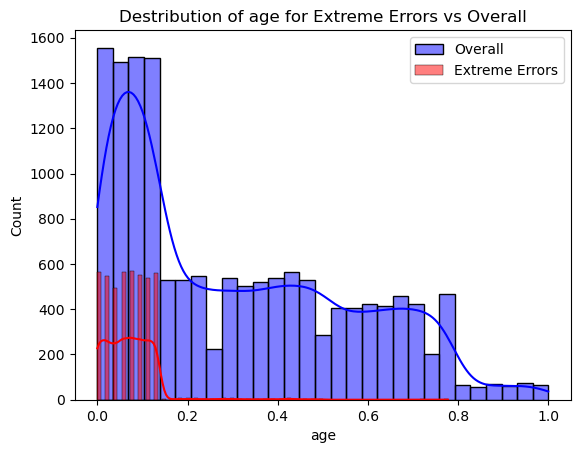

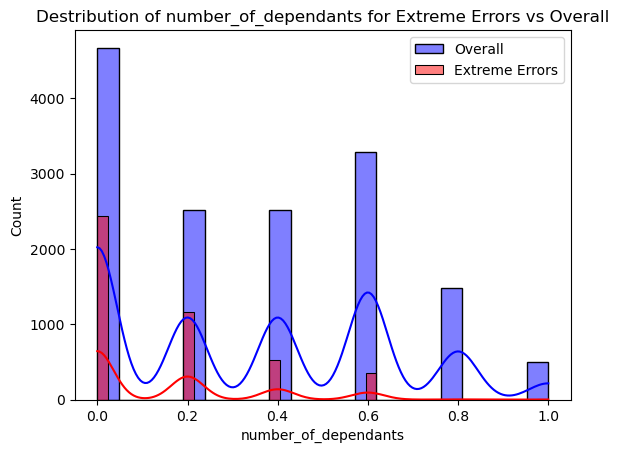

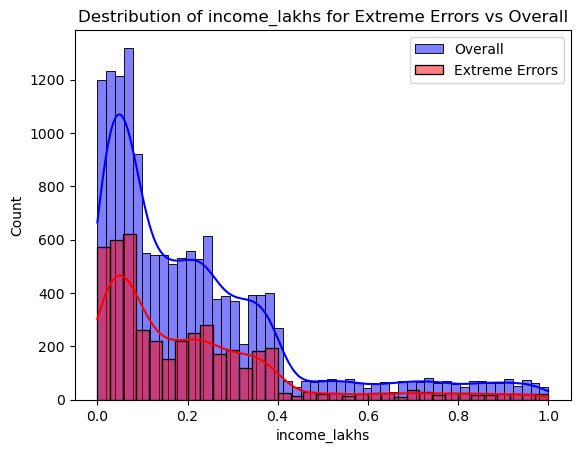

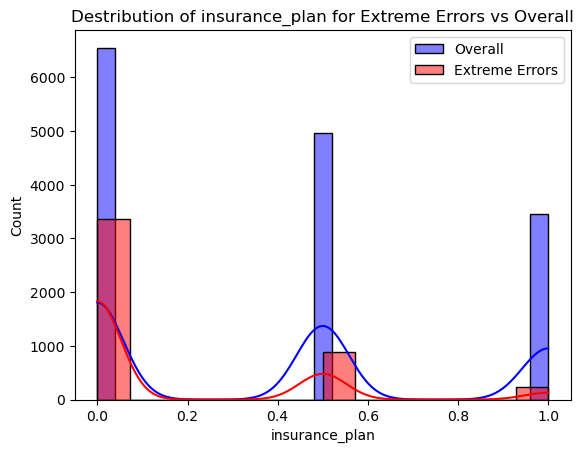

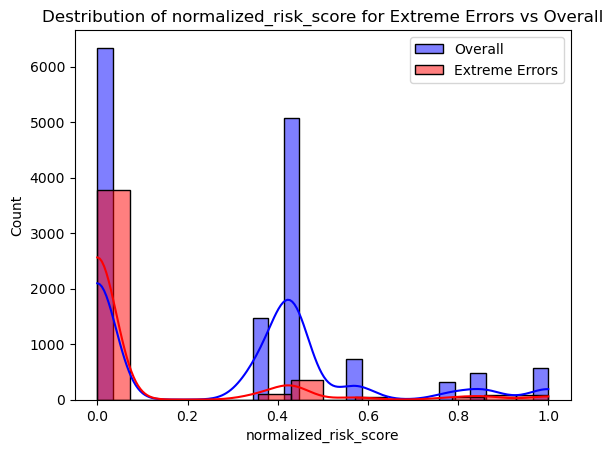

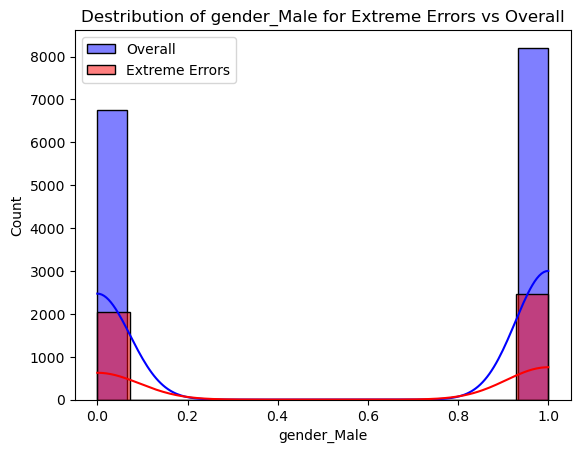

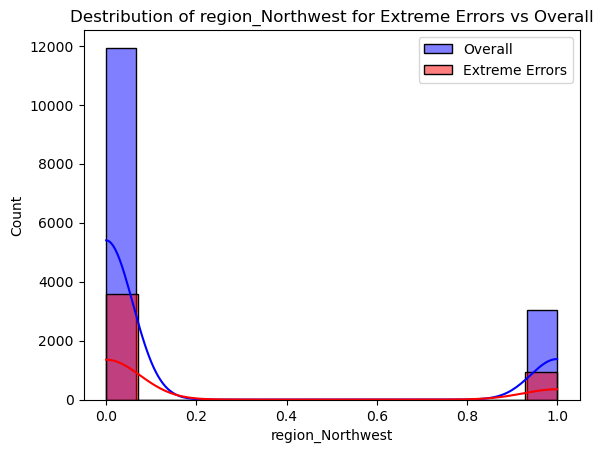

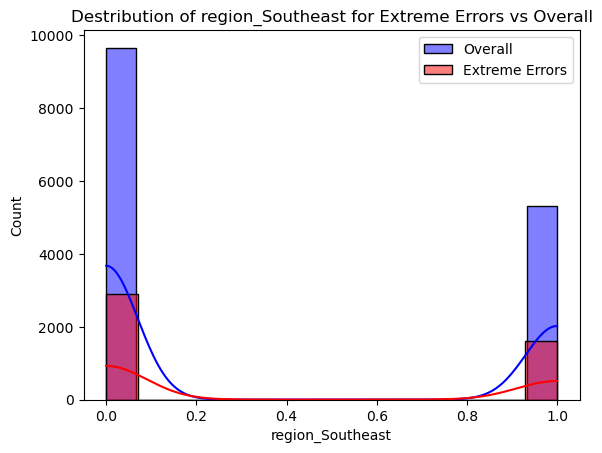

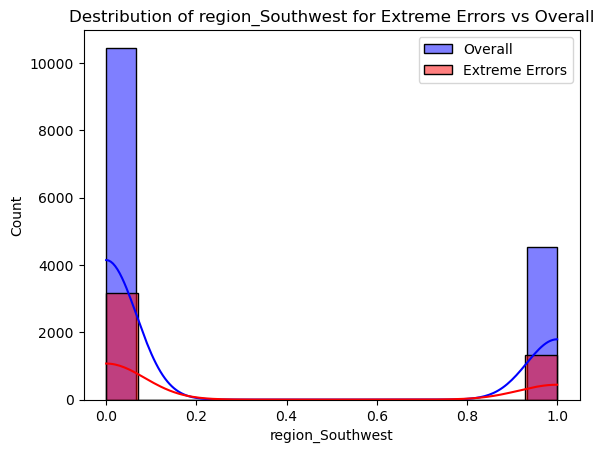

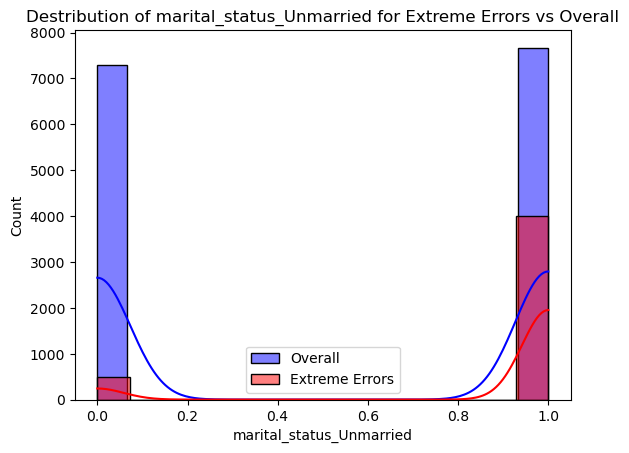

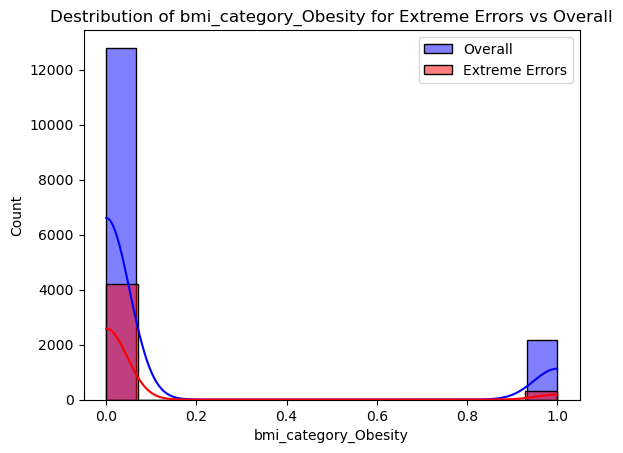

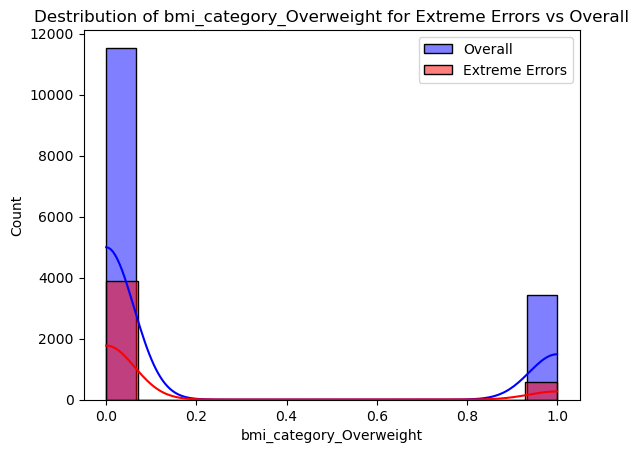

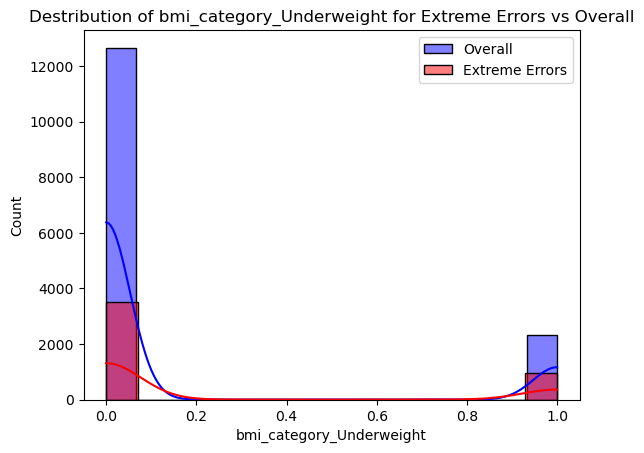

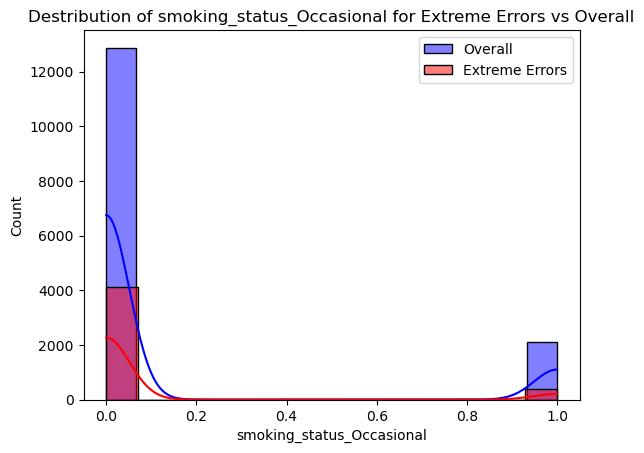

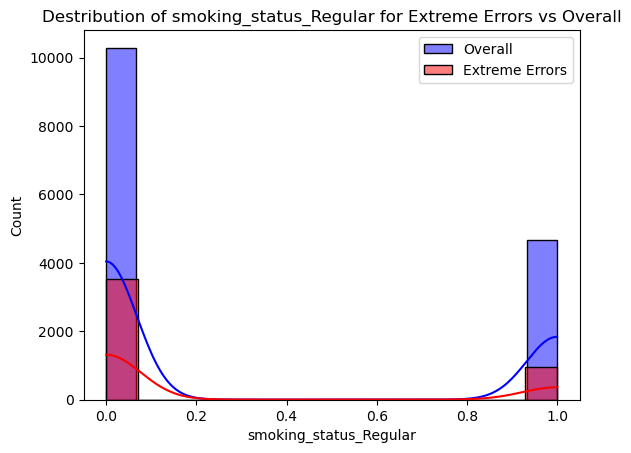

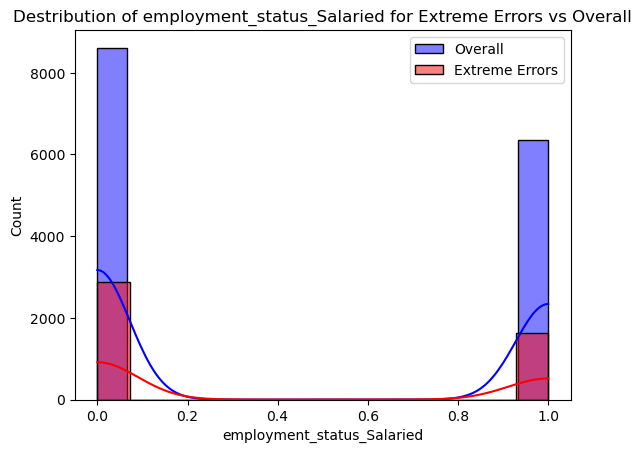

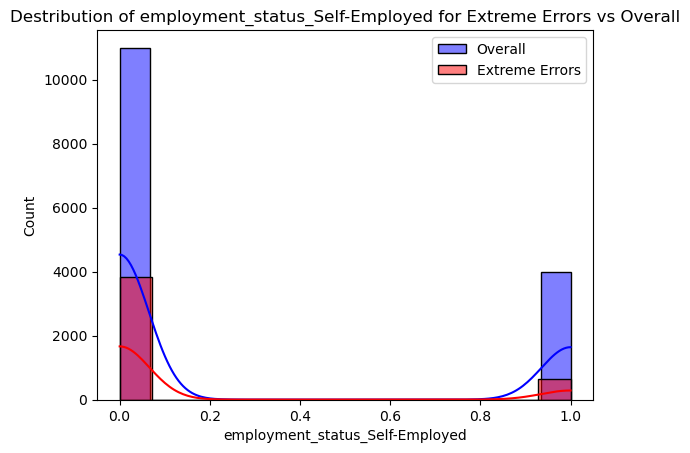

In [181]:
for col in X_test.columns:
    sns.histplot(X_test[col] ,label = "Overall",color = 'blue', kde = True)
    sns.histplot(extreme_errors_df[col] ,label = "Extreme Errors",color ='red', kde = True)
    plt.title(f'Destribution of {col} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()
        

In [ ]:
# insight : problem with lower age group

<Axes: xlabel='age', ylabel='Count'>

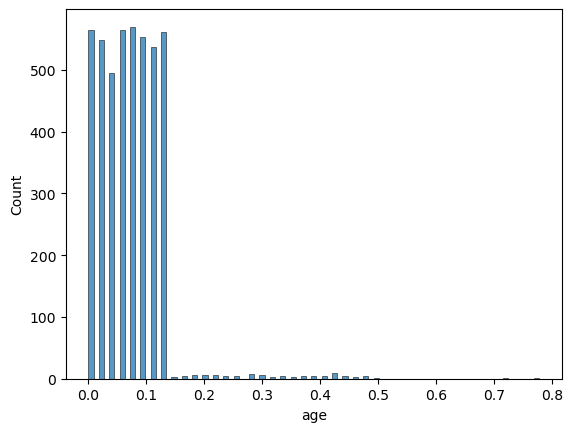

In [182]:
sns.histplot(extreme_errors_df.age)

In [194]:
# we want see real ages  , going to reversed that , scaled data before


df_reversed = pd.DataFrame()

extreme_errors_df['income_level'] = -1    # we want add because we doped that column after scaling
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed





,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0
...,...,...,...,...,...
4482,19.0,1.0,-2.0,8.0,1.0
4483,25.0,0.0,-2.0,12.0,1.0
4484,21.0,0.0,-2.0,7.0,2.0
4485,21.0,1.0,-2.0,8.0,1.0


<Axes: xlabel='age', ylabel='Count'>

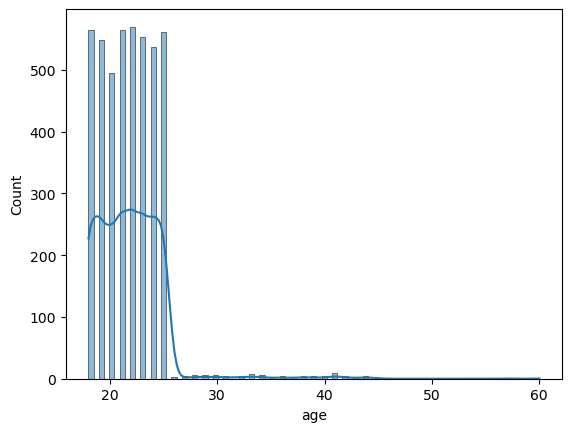

In [195]:
sns.histplot(df_reversed['age'] , kde =True)

In [196]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4487.000000,4487.000000,4487.0,4487.000000,4487.000000
mean,21.804992,0.739247,-2.0,21.182527,1.302429
std,3.172355,0.968855,0.0,20.598596,0.563135
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000


In [204]:
for i in np.arange(0.75, 1.0, 0.01):
    qv = (round(i, 2))
    print(f"Quantile : {qv}   Age up to : {df_reversed['age'].quantile(qv)}")

Quantile : 0.75   Age up to : 24.0
Quantile : 0.76   Age up to : 24.0
Quantile : 0.77   Age up to : 24.0
Quantile : 0.78   Age up to : 24.0
Quantile : 0.79   Age up to : 24.0
Quantile : 0.8   Age up to : 24.0
Quantile : 0.81   Age up to : 24.0
Quantile : 0.82   Age up to : 24.0
Quantile : 0.83   Age up to : 24.0
Quantile : 0.84   Age up to : 24.0
Quantile : 0.85   Age up to : 24.0
Quantile : 0.86   Age up to : 25.0
Quantile : 0.87   Age up to : 25.0
Quantile : 0.88   Age up to : 25.0
Quantile : 0.89   Age up to : 25.0
Quantile : 0.9   Age up to : 25.0
Quantile : 0.91   Age up to : 25.0
Quantile : 0.92   Age up to : 25.0
Quantile : 0.93   Age up to : 25.0
Quantile : 0.94   Age up to : 25.0
Quantile : 0.95   Age up to : 25.0
Quantile : 0.96   Age up to : 25.0
Quantile : 0.97   Age up to : 25.0
Quantile : 0.98   Age up to : 27.0
Quantile : 0.99   Age up to : 35.0


In [205]:
# insight : 95 % of extreme error records have age 25 or less